# Import Library

In [6]:
import os
import fnmatch as fn
import numpy as np
import pandas as pd
#!pip install dbfread
import dbfread

#!pip install pandas_profiling
import pandas_profiling as pp
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import font_manager, rc
%matplotlib inline
#%matplotlib notebook

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from math import sin,cos,sqrt,atan2,radians 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
import tbats
#import fbprophet

import requests
import logging
import time
import googlemaps
import reverse_geocoder
import pprint
import folium
import zipfile
import json
#%matplotlib.inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from xgboost import XGBRegressor
import lightgbm as lgb


matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 기호도 표시

# 한글 깨짐 방지 목적 #
font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family = font_name)

## 맥
# rc('font', family='/Library/Fonts/AppleGothic.ttf')


# 만약 plotly가 설치 되지 않았을 경우 하단의 코드를 실행할 것 #
#!pip install plotly
import plotly
#!pip install cufflinks
#import plotly.express as px
# Cufflinks wrapper on plotly
import cufflinks as cf
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
from plotly.offline import init_notebook_mode, plot,iplot

init_notebook_mode(connected = True)
cf.go_offline()

import warnings
warnings.filterwarnings(action='ignore') # 경고 메시지를 숨길 때

# Import Data

In [7]:
df = pd.read_csv('가공데이터/merge_유통_유동_환경_소상공인_edit1.csv')
df = df.iloc[:,1:]
df['date'] = pd.to_datetime(df['date'],format = '%Y-%m-%d')

df_revised = pd.read_csv('가공데이터/merge_유통_유동_환경_소상공인_edit2.csv')
df_revised = df_revised.iloc[:,1:]
df_revised['date'] = pd.to_datetime(df_revised['date'],format = '%Y-%m-%d')

In [8]:
shape_visual = gpd.read_file('Rawdata/유동인구데이터/행정동경계파일/종로_노원_행정동.shp',
                             encoding = 'euckr')

ad = dbfread.DBF('Rawdata/유동인구데이터/행정동경계파일/종로_노원_행정동.dbf')
ad = pd.DataFrame(iter(ad))

ad['X_COORD'] = ad['X_COORD'].apply(float)
ad['Y_COORD'] = ad['Y_COORD'].apply(float)

g_info = [Point(i) for i in zip(ad['X_COORD'],ad['Y_COORD'])]

geo_ad = gpd.GeoDataFrame(ad,
                          crs = {'init' : 'epsg:4326'},
                          geometry = g_info
                         )
geo_ad.head()

,STD_YYYY,HDONG_CD,HDONG_NM,SIDO_CD,SIDO_NM,SGNG_CD,SGNG_NM,AREA,LENGTH,X_COORD,Y_COORD,geometry
0,2019,1111051500,청운효자동,11,서울특별시,11110,종로구,2573175.62,7975.05,126.972694,37.581306,POINT (126.972694 37.581306)
1,2019,1111053000,사직동,11,서울특별시,11110,종로구,1128161.02,5498.40,126.970919,37.573408,POINT (126.9709195 37.573408)
2,2019,1111054000,삼청동,11,서울특별시,11110,종로구,1478468.25,7377.76,126.984028,37.582083,POINT (126.984028 37.582083)
3,2019,1111055000,부암동,11,서울특별시,11110,종로구,2276588.99,8912.71,126.966500,37.589917,POINT (126.9665 37.589917)
4,2019,1111056000,평창동,11,서울특별시,11110,종로구,8951336.18,13312.43,126.968972,37.602583,POINT (126.968972 37.602583)


# 지리적 속성을 활용하여 변수들간의 관계를 파악

## 동별 Polygon 정보를 시각화하면 다음과 같다.

No handles with labels found to put in legend.


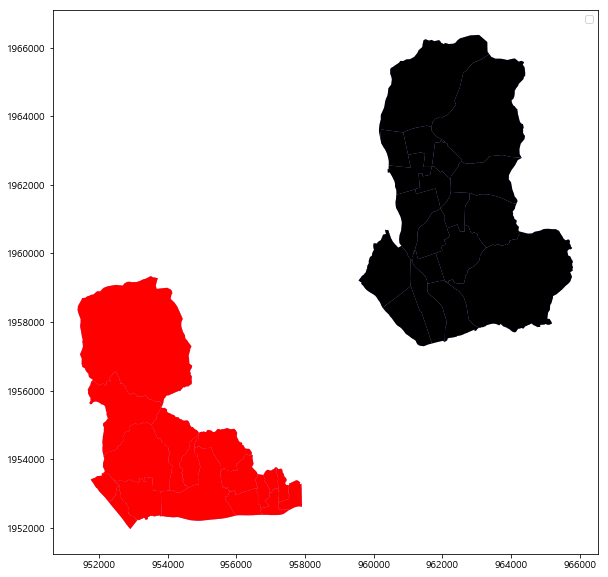

In [4]:
fig,ax = plt.subplots(figsize = (10,10))
shape_visual.plot(ax = ax, alpha=0.4,color = 'blue')
shape_visual[shape_visual['SGNG_CD'] == '11110'].plot(ax = ax, color = 'red',label='노원구')
shape_visual[shape_visual['SGNG_CD'] == '11350'].plot(ax = ax, color = 'black',label='종로구')
#ax.set_title('노원구 & 종로구')
plt.legend()

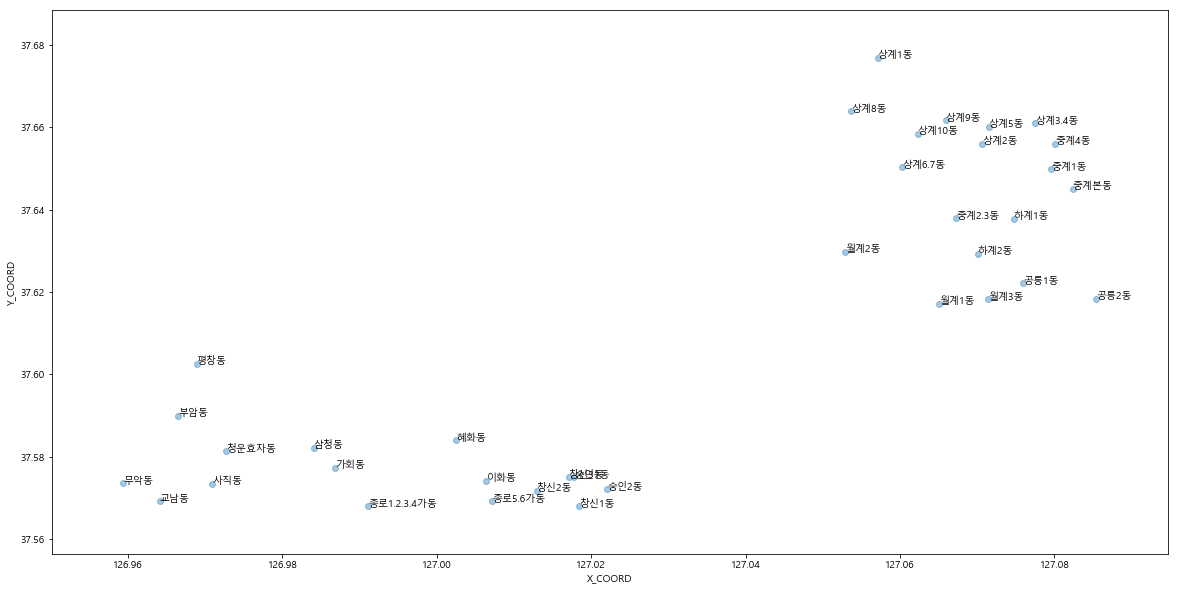

In [5]:
plt.figure(figsize = (20,10))
plt.scatter(geo_ad['X_COORD'],
            geo_ad['Y_COORD'],
            cmap = "YlOrRd",
            alpha = 0.4)
plt.xlabel('X_COORD')
plt.ylabel('Y_COORD')

for i in range(len(geo_ad['HDONG_NM'])):
    plt.text(geo_ad['X_COORD'][i],geo_ad['Y_COORD'][i],geo_ad['HDONG_NM'][i])

# 환경+유동+카드 불러오기

In [30]:
pop_card= pd.read_csv('가공데이터/merge_카드_유동_환경_edit1.csv')
pop_card = pop_card.iloc[:,1:]
pop_card['date'] = pd.to_datetime(pop_card['date'],format = '%Y-%m-%d')

In [50]:
tt = pd.DataFrame(pop_card.groupby(['district']).agg({'trans_pop':'mean', 'USE_AMT':'mean', 'USE_CNT':'mean'}))
#tt = pd.DataFrame(gs_retail_recent['행정동명'].value_counts())
tt['HDONG_NM'] = tt.index

In [86]:
tt['rate']=tt.USE_AMT/tt.trans_pop

In [84]:
rfile = open(r'Rawdata/유동인구데이터\행정동경계파일\종로_노원_행정동_wgs84.json','r',encoding='utf-8').read()
jsondata = json.loads(rfile)

jongro_nowon_map = folium.Map(location = [np.mean(geo_ad['Y_COORD']),np.mean(geo_ad['X_COORD'])],
                              zoom_start = 10.6)

jongro_nowon_map.choropleth(geo_data = jsondata,
                            data =tt , 
                            columns = ['HDONG_NM','trans_pop'],
                            key_on='feature.properties.HDONG_NM',
                            highlight=True,
                            fill_opacity=0.5,
                            line_opacity=1,
                            fill_color='RdPu',
                            legend_name="trans_pop"
                            )

In [85]:
jongro_nowon_map

In [94]:
jongro_nowon_map = folium.Map(location = [np.mean(geo_ad['Y_COORD']),np.mean(geo_ad['X_COORD'])],
                              zoom_start = 10.6)

jongro_nowon_map.choropleth(geo_data = jsondata,
                            data =tt , 
                            columns = ['HDONG_NM','USE_AMT'],
                            key_on='feature.properties.HDONG_NM',
                            highlight=True,
                            fill_opacity=0.5,
                            line_opacity=1,
                            fill_color='RdPu',
                            legend_name="USE_AMT"
                            )

In [95]:
jongro_nowon_map

In [87]:
jongro_nowon_map = folium.Map(location = [np.mean(geo_ad['Y_COORD']),np.mean(geo_ad['X_COORD'])],
                              zoom_start = 10.6)

jongro_nowon_map.choropleth(geo_data = jsondata,
                            data =tt , 
                            columns = ['HDONG_NM','rate'],
                            key_on='feature.properties.HDONG_NM',
                            highlight=True,
                            fill_opacity=0.5,
                            line_opacity=1,
                            fill_color='RdPu',
                            legend_name="rate"
                            )

### 유동과 카드가 동별로 비슷하게 나타나는 것을 확인할 수 있다.

In [93]:
tt.corr()

,trans_pop,USE_AMT,USE_CNT,rate
trans_pop,1.000000,0.795852,0.859333,-0.266071
USE_AMT,0.795852,1.000000,0.957090,0.296505
USE_CNT,0.859333,0.957090,1.000000,0.137381
rate,-0.266071,0.296505,0.137381,1.000000


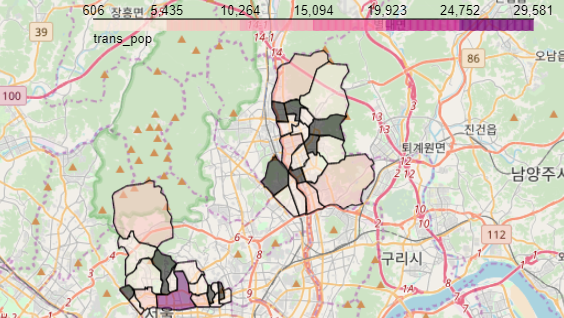

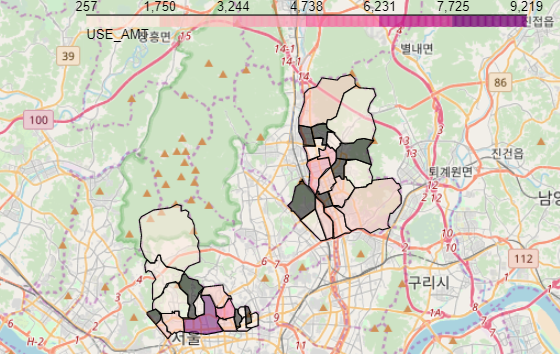